In [1]:
import sys
from glob import glob
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes

from astropy.table import Table
import pandas as pd
from astropy.table import unique, join
from sklearn.preprocessing import minmax_scale
from scipy.stats import skew, kurtosis

In [2]:
from source_names_dict import source_names_dict, source_names_w_counterparts, source_names_readable
from get_closest_srcreg import get_src_region_dict
from uvot import read_uvotsource, calc_uvot_flags, filters, filter_colors, filter_markers
from xrt import load_xrt, rename_xrt_cols
from lightcurve import LightCurve

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [4]:
# Fix glob square bracket issue
to_replace = {'[':'[[]',
              ']':'[]]'}

In [5]:
src_region_dict = get_src_region_dict()

Getting source region dict


Reading uvotsource...
Reading file ../download_scripts/NGC1313/X-2_src_uvotsource_all.fits
tab len=538 unique_obs=485
UVOT flag summary:
FLAG_AB_MAG_99      = 15 / 538 (2.79%)
FLAG_UPPER_LIM      = 23 / 538 (4.28%)
FLAG_AB_MAG_ERR>2   = 15 / 538 (2.79%)
FLAG_AB_MAG_>10_<30 = 15 / 538 (2.79%)
Calculating Lomb scargle periodogram using autopower
min(frequency) = 0.00 max(frequency) = 1.00
pow=0.13 freq=2.76e-03 p=362.52 fap=0.31
LS success
{'ndata': 276, 'mean': 19.07476, 'std': 0.24709158, 'max': 20.47068, 'min': 16.92185, 'max/min': 1.2097188, 'sigma_xs': 0.045908251804286156, 'F_var': 0.011232754967505388, 'kurtosis': 22.987610512347306, 'von_neumann': 1.4771712051790622, 'skew': -1.7715792880859882, 't_diff_max': 1026.1906805445615, 't_diff_min': 0.0, 't_diff_mean': 20.26543140641456, 'y_diff_max': 2.1606483, 'y_diff_min': -2.262066, 'y_diff_mean': 0.001277778, 'ls_z_fal': <Quantity 0.26126726>, 'ls_pow[0]': 0.13080157743270912, 'ls_freq[0]': 0.002758480385721459, 'ls_period[0]': 362

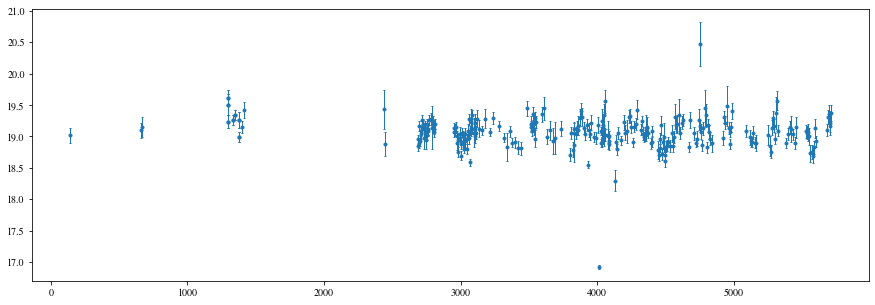

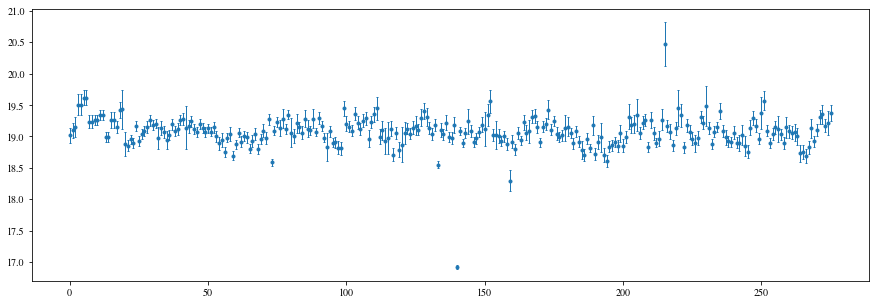

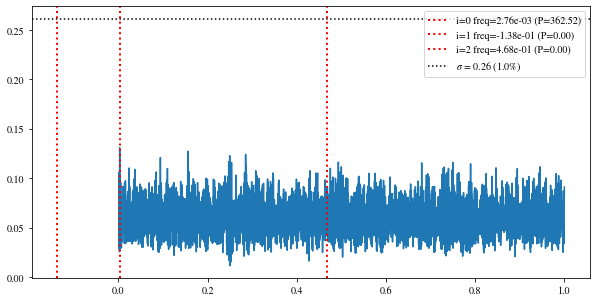

Getting lightcurve gtis...


([[0, 0], [1, 2], [3, 18], [19, 20], [21, 47], [48, 275]],
 [[137, 138],
  [657, 670],
  [1294, 1415],
  [2440, 2447],
  [2686, 2815],
  [2950, 5711]])

In [6]:
tab_uvot = read_uvotsource(f'../download_scripts/NGC1313/X-2_src_uvotsource_all.fits')
tab_uvot = tab_uvot[tab_uvot['FILTER'] == 'U']
lc = LightCurve(tab_uvot['MJD_0'], tab_uvot['MAG'], tab_uvot['MAG_ERR'])
res = lc.analyse()
print(res)
lc.plot_all()
lc.gtis

In [7]:
lc

In [8]:
print(f"""From the starting sample of {len(source_names_dict)} sources we filtered out {len(source_names_dict) - len(source_names_w_counterparts)} sources that did not
have plausable UV counterparts in the stacked UVOT image leaving us with {len(source_names_w_counterparts)} sources.
The subset of selected sources is as follows:""")

From the starting sample of 40 sources we filtered out 23 sources that did not
have plausable UV counterparts in the stacked UVOT image leaving us with 17 sources.
The subset of selected sources is as follows:


In [9]:
for s in source_names_w_counterparts:
    print(f'{s:<40} {source_names_dict[s]:<30} {source_names_readable[s]}')

[LB2005]_NGC_3031_X6                     M81                            M81 X-6
RX_J133001+47137                         M51                            M51 ULX-7
NAME_NGC_1313_X-2                        NGC1313                        NGC1313 X-2
[SK2009]_X2                              NGC1365                        NGC1365 X-2
[LB2005]_NGC_6946_ULX3                   NGC6946                        NGC6946 ULX-3
NAME_NGC_300_ULX1                        NGC300                         NGC300 ULX-1
SWIFT_J0243.6+6124                       Swift_J0243.6+6124             Swift_J0243.6+6124
Holmberg_II_X-1                          Holmberg_II                    Holmberg II X-1
NOVA_Cyg_1989                            V404Cyg                        V404Cyg
[LM2005]_NGC_4559_ULX1                   NGC4559                        NGC4559 ULX-1
NAME_NGC_7793_P13                        NGC7793                        NGC7793 P13
NAME_NGC_925_ULX-2                       NGC925                       

In [10]:
all_d = []
print('Getting Number of observations...')
for simbad_name in source_names_w_counterparts:
    simbad_name_glob = simbad_name.translate(str.maketrans(to_replace)) # Used to fix globbing square brackets
    local_name    = source_names_dict[simbad_name]
    readable_name = source_names_readable[simbad_name]
    closest_src   = src_region_dict[simbad_name]
    fits_files = glob(f'../download_scripts/{local_name}/*uvotsource*fits*')
    csv_files  = glob(f'../UKSSDC/{simbad_name_glob}/*/*/curve_PC.csv')
    
    for f in fits_files:
        if closest_src.split('/')[-1][:-4] in f:
            tab = read_uvotsource(f)
            d = {}
            #d['uvotsource_file'] = f
            # d['simbad_name'] = simbad_name
            d['readable_name'] = readable_name

            for filt in filters:
                sub = tab[tab['FILTER'] == filt]
                d[filt] = len(np.unique(sub['OBSID']))

    for csv in csv_files:
        df_xrt = pd.read_csv(csv, dtype={'obsID':str})
        d['XRT_PC'] = int(len(np.unique(df_xrt['obsID'])))
    all_d.append(d)
    
df = pd.DataFrame(all_d)
df = df.fillna(0)
df['XRT_PC'] = df['XRT_PC'].astype(int)
df['UVOT_TOT'] = df[filters].sum(axis=1)
df = df.sort_values(['XRT_PC'], ascending=False)
with open('../tables/uvot_obs.tex', 'w+') as f: 
    df.to_latex(f, index=False)
df

Getting Number of observations...
Reading uvotsource...
Reading file ../download_scripts/M81/X6_src_uvotsource_all.fits
tab len=970 unique_obs=468
UVOT flag summary:
FLAG_AB_MAG_99      = 28 / 970 (2.89%)
FLAG_UPPER_LIM      = 83 / 970 (8.56%)
FLAG_AB_MAG_ERR>2   = 29 / 970 (2.99%)
FLAG_AB_MAG_>10_<30 = 28 / 970 (2.89%)
Reading uvotsource...
Reading file ../download_scripts/M51/ULX7_src_uvotsource_all.fits
tab len=589 unique_obs=261
UVOT flag summary:
FLAG_AB_MAG_99      = 0 / 589 (0.00%)
FLAG_UPPER_LIM      = 0 / 589 (0.00%)
FLAG_AB_MAG_ERR>2   = 0 / 589 (0.00%)
FLAG_AB_MAG_>10_<30 = 0 / 589 (0.00%)
Reading uvotsource...
Reading file ../download_scripts/NGC1313/X-2_src_uvotsource_all.fits
tab len=538 unique_obs=485
UVOT flag summary:
FLAG_AB_MAG_99      = 15 / 538 (2.79%)
FLAG_UPPER_LIM      = 23 / 538 (4.28%)
FLAG_AB_MAG_ERR>2   = 15 / 538 (2.79%)
FLAG_AB_MAG_>10_<30 = 15 / 538 (2.79%)
Reading uvotsource...
Reading file ../download_scripts/NGC1365/X2_src_uvotsource_all.fits
tab len=4

/tmp/ipykernel_16250/2713018815.py:34: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(f, index=False)


,readable_name,B,U,V,UVM2,UVW1,UVW2,WHITE,XRT_PC,UVOT_TOT
2,NGC1313 X-2,3,269,2,96,56,66,0,452,492
7,Holmberg II X-1,3,101,3,34,58,52,0,227,251
10,NGC7793 P13,0,151,0,0,4,4,0,223,159
1,M51 ULX-7,66,119,61,109,98,107,0,168,560
8,V404Cyg,22,73,23,9,21,10,24,129,182
4,NGC6946 ULX-3,83,89,79,24,69,44,0,108,388
12,NGC925 ULX-1,0,16,0,29,41,41,0,91,127
15,SMC X-3,1,9,1,11,10,6,0,89,38
9,NGC4559 ULX-1,7,23,6,19,55,56,1,89,167
5,NGC300 ULX-1,48,61,43,53,69,68,0,71,342


In [11]:
for simbad_name in source_names_w_counterparts:
    local_name    = source_names_dict[simbad_name]
    readable_name = source_names_readable[simbad_name]
    closest_src   = src_region_dict[simbad_name]
    fits_files = glob(f'../download_scripts/{local_name}/*uvotsource*fits*')
    
    for f in fits_files:
        if closest_src.split('/')[-1][:-4] in f:
            fig = plt.figure(figsize=(20,4))
            tab = read_uvotsource(f)
            MJD_MIN = tab['MJD'].min()
            
            gti_indexs, gtis = get_gtis(tab['MJD_0'])

            ax = fig.add_subplot()

            for filt in np.unique(tab['FILTER']):
                sub = tab[tab['FILTER'] == filt]
                
                ax.errorbar(sub['MJD_0'], sub['MAG'], yerr=sub['MAG_ERR'], lw=1.0, ls='none', capsize=1.0,
                            label=filt, color=filter_colors[filt], marker='.')
                #bax.errorbar(sub['MJD'], sub['COI_SRC_RATE'], yerr=sub['COI_SRC_RATE_ERR'], lw=1.0, ls='none', capsize=1.0, marker='.', label=filt)
                
            ax.legend()
            ax.set_title(readable_name)
            ax.set_ylabel('Brightness (MAG)')
            ax.set_xlabel(f'Time since MJD={int(MJD_MIN)} (MJD)')
            plt.savefig(f'../figures/uvot_lightcurves/{simbad_name}.png', bbox_inches='tight', pad_inches = 0)
            plt.savefig(f'../figures/uvot_lightcurves/{simbad_name}.pdf', bbox_inches='tight', pad_inches = 0)
            
            plt.show()

Reading uvotsource...
Reading file ../download_scripts/M81/X6_src_uvotsource_all.fits
tab len=970 unique_obs=468
UVOT flag summary:
FLAG_AB_MAG_99      = 28 / 970 (2.89%)
FLAG_UPPER_LIM      = 83 / 970 (8.56%)
FLAG_AB_MAG_ERR>2   = 29 / 970 (2.99%)
FLAG_AB_MAG_>10_<30 = 28 / 970 (2.89%)


NameError: name 'get_gtis' is not defined

<Figure size 1440x288 with 0 Axes>

In [ ]:
for simbad_name in source_names_w_counterparts:
    local_name    = source_names_dict[simbad_name]
    readable_name = source_names_readable[simbad_name]
    closest_src   = src_region_dict[simbad_name]
    fits_files = glob(f'../download_scripts/{local_name}/*uvotsource*fits*')
    
    for f in fits_files:
        if closest_src.split('/')[-1][:-4] in f:
            fig = plt.figure(figsize=(20,4))
            tab = read_uvotsource(f)
            
            MJD_MIN = tab['MJD'].min()
            
            gti_indexs, gtis = get_gtis(tab['MJD_0'])
            if len(gtis) > 1:
                bax = brokenaxes(xlims=gtis)
            else:
                bax = fig.add_subplot()

            for filt in np.unique(tab['FILTER']):
                sub = tab[tab['FILTER'] == filt]                    
                bax.errorbar(sub['MJD_0'], sub['MAG'], yerr=sub['MAG_ERR'], lw=1.0, ls='none', capsize=1.0, marker='.', label=filt)
                #bax.errorbar(sub['MJD'], sub['COI_SRC_RATE'], yerr=sub['COI_SRC_RATE_ERR'], lw=1.0, ls='none', capsize=1.0, marker='.', label=filt)
                
            bax.legend()
            bax.set_title(readable_name)
            bax.set_ylabel('RAW_TOT_RATE')
            bax.set_xlabel(f'Time since MJD={int(MJD_MIN)} (MJD)')
            plt.show()

In [ ]:
all_res = []

for simbad_name in source_names_w_counterparts:
    readable_name = source_names_readable[simbad_name]
    local_name    = source_names_dict[simbad_name]
    fits_files = glob(f'../download_scripts/{local_name}/*uvotsource*fits*')
    
    for f in fits_files:
        tab = read_uvotsource(f)
        for filt in np.unique(tab['FILTER']):
            res = {}
            sub = tab[tab['FILTER'] == filt]
            
            
            res['uvotsource_path'] = f
            res['simbad_name'] = simbad_name
            res['readable_name'] = readable_name
            res['filter'] = filt
            res['ndata'] = len(sub)
            res['MAG_mean'] = sub['MAG'].mean()
            res['MAG_std'] = sub['MAG'].std()
            res['MAG_var'] = sub['MAG'].var()
            res['MAG_F_var'] = calc_F_var(sub['MAG'], sub['MAG_ERR'])
            res['MAG_sigma_xs'] = calc_sigma_xs(sub['MAG'], sub['MAG_ERR'])
            res['MAG_skew'] = skew(sub['MAG'])
            res['MAG_kurt'] = kurtosis(sub['MAG'])
            res['MAG_von_neumann'] = calc_von_neumann_stat(sub['MAG'])
            
            all_res.append(res)
            
            
            print(f'{simbad_name:<40} {local_name:<20} #_fits={len(fits_files):<5} {f:<40} {filt} len={len(sub)}')
            # Plotting

            fig, ax = plt.subplots(2,1, figsize=(15,5))
            ax[0].set_title(f'{simbad_name} | {local_name} | {readable_name} | FILTER= {filt} \n ndata={res["ndata"]} \t $\mu$={res["MAG_mean"]:.2f} \t $\sigma$={res["MAG_std"]:.2f} $\gamma$={res["MAG_skew"]:.2f} \t $\eta$={res["MAG_von_neumann"]:.2f} \t Kurt={res["MAG_kurt"]:.2f} \t $F_{{var}}$={res["MAG_F_var"]:.2f} ({res["MAG_F_var"]*100:.2f}%) \t $\sigma_{{xs}}=${res["MAG_sigma_xs"]:.2f}')
            ax[0].errorbar(sub['MJD'], sub['MAG'], yerr=sub['MAG_ERR'], lw=1.0, ls='none', label=filt, capsize=1.0)
            ax[1].errorbar(range(len(sub)), sub['MAG'], yerr=sub['MAG_ERR'], lw=1.0, ls='none', label=filt, capsize=1.0)
            ax[0].legend()
            ax[1].legend()
            plt.show()
            

In [ ]:
df = pd.DataFrame(all_res)
df

In [ ]:
with open('../tables/uvot_obs.tex', 'w+') as f:
    df.sort_values(['readable_name', 'filter'])[['readable_name', 'filter', 'ndata']].to_latex(buf=f)

In [ ]:
curves =  glob(f'../UKSSDC/{simbad_name}/*/*/*.csv')
curves

In [ ]:
from sklearn.preprocessing import scale

In [ ]:
#simbad_name = 'NAME_NGC_300_ULX1'

simbad_name = 'NAME_NGC_1313_X-2'

local_name  = source_names_dict[simbad_name]
readable_name = source_names_readable[simbad_name]

uvot_filter = 'U'
xrt_curve = 'HARD'

xrt_rate      = 'RATE'
xrt_rate_err  = 'RATE_ERR'

uvot_rate     = 'RAW_TOT_RATE'
uvot_rate_err = 'RAW_TOT_RATE_ERR'

# Load X-ray Data
tab_xrt_full = load_xrt(simbad_name=simbad_name, curve=xrt_curve, pandas=False)
tab_xrt_full = rename_xrt_cols(tab_xrt_full)

# Load UV Data
tab_uvot = read_uvotsource(f'../download_scripts/NGC1313/X-2_src_uvotsource_all.fits')
tab_uvot = tab_uvot[tab_uvot['FILTER'] == uvot_filter]
tab_uvot = unique(tab_uvot, keys='OBSID')

# Join Data
tab_join = join(tab_uvot, tab_xrt_full , join_type='inner', keys='OBSID')
#tab_join = tab_join[tab_join['MAG'] > 17]
#tab_join = tab_join[tab_join['RATE'] < 0.04]

# Get x,y data
t = tab_join['MJD_0']

x = tab_join[uvot_rate]
x_err = tab_join[uvot_rate_err]

y = tab_join[xrt_rate]
y_err = tab_join[xrt_rate_err]

#y_err = (abs(tab_join['RATE_ERR_NEG']), tab_join['RATE_ERR_POS'])
#y_err = tab_join['RATE_ERR_POS'] - tab_join['RATE_ERR_NEG']


# scale data
x = scale(x)
y = scale(y)
#x = minmax_scale(x)
#y = minmax_scale(y)

# Plot lightcurve
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(range(len(x)), x, lw=1.0, label=f'XRT {xrt_curve} | {xrt_rate}', ls='-', marker='.')
ax.plot(range(len(y)), y, lw=1.0, label=f'UVOT {uvot_filter} | {uvot_rate}', ls='-', marker='.')
ax.legend()

# Plot correlation
plt.figure(figsize=(5,5))
#plt.errorbar(x, y, xerr=x_err, yerr=y_err,  lw=1.0, capsize=1.0, ls='none')
plt.scatter(x, y, marker='x')
plt.title(readable_name)
plt.xlabel(f'{uvot_filter} {uvot_rate} (ct/s)')
plt.ylabel(f'{xrt_curve} {xrt_rate} (ct/s)')

# Plot CCF
from scipy import signal
from scipy.stats import pearsonr

lags = np.arange(-len(x) + 1, len(x))
c = signal.correlate(x / np.std(x), y / np.std(y), 'full') 
c = c / len(x)
r, p_val = pearsonr(x,y)
lag_max = lags[np.argmax(c)]

plt.figure(figsize=(5,5))
plt.plot(lags, c, label='CCF')
plt.axvline(lag_max, color='red', label=f'{lag_max}')
plt.legend()
plt.xlabel('Lag (datapoints)')
plt.ylabel('CCF')
plt.show()

#calculate autocorrelations
import statsmodels.api as sm
acf_y = sm.tsa.acf(y, nlags=2*len(y))
acf_x = sm.tsa.acf(x, nlags=2*len(x))

plt.figure(figsize=(5,5))
plt.plot(acf_x, label=f'ACF UVOT')
plt.plot(acf_y, label=f'ACF XRT')

plt.legend()

In [ ]:
r

In [ ]:
x_bin_lo = 0
x_bin_hi = 0.25

tab_sub = tab_join[(tab_join['RATE'] < x_bin_hi) & (tab_join['RATE'] > x_bin_lo)]

In [ ]:
tab_sub

In [ ]:
n_data_bin = 10 # Number of datapoints per bin
bin_low = 0
bin_high = 0

plt.figure(figsize=(5,5))
while bin_high < len(x):
    bin_high = bin_low + n_data_bin
    x_sub = x[bin_low:bin_high]
    y_sub = y[bin_low:bin_high]
    
    x_mu  = np.mean(x_sub)
    x_std = np.std(x_sub, ddof=1) / np.sqrt(np.size(x_sub))
    y_mu  = np.mean(y_sub)
    y_std = np.std(y_sub, ddof=1) / np.sqrt(np.size(y_sub))
    
    plt.errorbar(x=x_mu, y=y_mu, xerr=x_std, yerr=y_std, color='black', lw=1.0, capsize=1.0)
    #print(bin_low, bin_high)
    bin_low+=n_data_bin
plt.show()

In [ ]:
def line_cf(x, m, c):
    """ Line function for use in curve_fit."""
    y = m*x+c
    return y

def line(B, x):
    """ Line function for use in odr
    y = mx+c
    B[0] : m
    B[1] : c
    """
    y = B[0]*x+B[1]
    return y

m = 1.0
c = 0
size = 100


In [ ]:
from scipy.optimize import curve_fit
from tqdm import tqdm
# Create a realisations from out data and fit
def sample_data(x_data, y_data, x_err, y_err):
    x_samp = np.empty(len(x_data))
    y_samp = np.empty(len(x_data))
    for i in range(len(x_data)):
        x_mu  = x_data[i] 
        x_std = x_err[i]
        y_mu  = y_data[i]
        y_std = y_err[i]
        x_samp[i] = np.random.normal(loc=x_mu, scale=x_std)
        y_samp[i] = np.random.normal(loc=y_mu, scale=y_std)
        
    return x_samp, y_samp

m_opts = []
c_opts = []

for i in tqdm(range(10000)):
    x_samp, y_samp = sample_data(x, y, x_err, y_err)
    p_opt, p_cov = curve_fit(line_cf, x_samp, y_samp)
    m_opt, c_opt = p_opt
    m_opts.append(m_opt)
    c_opts.append(c_opt)

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].hist(m_opts, bins=100)
ax[1].hist(c_opts, bins=100)
ax[0].set_title('m')
ax[1].set_title('c')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(x_samp, y_samp, marker='x')
xlow, xhigh = ax.get_xlim()

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(x_samp, y_samp, marker='x')
xrange = np.linspace(xlow, xhigh, 100)
for i in range(1000):
    plt.plot(xrange, line_cf(xrange, m_opts[i], c_opts[i]), color='grey')

In [ ]:
# Fit the original data using Orthogonal distance regression
import scipy.odr as odr
linear = odr.Model(line)
mydata = odr.RealData(x, y, sx=x_err, sy=y_err)
myodr  = odr.ODR(mydata, linear, beta0=[1., 0.])
myoutput = myodr.run()
myoutput.pprint()

In [ ]:
m_opt, c_opt = myoutput.beta[0], myoutput.beta[1]

In [ ]:
xrange = np.linspace(x_data.min(), x_data.max(), 100)
plt.figure(figsize=(5,5))
plt.errorbar(x_data, y_data, xerr=x_err, yerr=y_err, ls='none', capsize=1.0, lw=1.0)
plt.plot(xrange, line([m_opt, c_opt], xrange))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import correlate

def plot_xcorr(x, y): 
    "Plot cross-correlation (full) between two signals."
    lags = np.arange(-len(x) + 1, len(x)) 
    c = correlate(x / np.std(x), y / np.std(y), 'full') 
    plt.plot(lags, c / len(x)) 
    plt.show() 
    
plot_xcorr(x, y)

In [ ]:
np.correlate(x,y, mode='full')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.timeseries import LombScargle


def simulated_data(N, rseed=2, period=0.41, phase=0.0):
    """Simulate data based from a pre-computed empirical fit"""

    # coefficients from a 5-term Fourier fit to SDSS object 1019544
    coeffs = [-0.0191, 0.1375, -0.1968, 0.0959, 0.075,
              -0.0686, 0.0307, -0.0045, -0.0421, 0.0216, 0.0041]

    rand = np.random.default_rng(rseed)
    t = phase + np.arange(N, dtype=float)
    t += 0.1 * rand.standard_normal(N)
    dmag = 0.01 + 0.03 * rand.random(N)

    omega = 2 * np.pi / period
    n = np.arange(1 + len(coeffs) // 2)[:, None]

    mag = (15 + dmag * rand.standard_normal(N)
           + np.dot(coeffs[::2], np.cos(n * omega * t)) +
           + np.dot(coeffs[1::2], np.sin(n[1:] * omega * t)))

    return t, mag, dmag


# generate data and compute the periodogram
t, mag, dmag = simulated_data(50)
ls = LombScargle(t, mag, dmag, normalization='standard')
freq, PLS = ls.autopower(minimum_frequency=1 / 1.2,
                         maximum_frequency=1 / 0.2)
best_freq = freq[np.argmax(PLS)]
phase = (t * best_freq) % 1

# compute the best-fit model
phase_fit = np.linspace(0, 1)
mag_fit = ls.model(t=phase_fit / best_freq,
                   frequency=best_freq)

# set up the figure & axes for plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle('Lomb-Scargle Periodogram (period=0.41 days)')
fig.subplots_adjust(bottom=0.12, left=0.07, right=0.95)
inset = fig.add_axes([0.78, 0.56, 0.15, 0.3])

# plot the raw data
ax[0].errorbar(t, mag, dmag, fmt='ok', elinewidth=1.5, capsize=0)
ax[0].invert_yaxis()
ax[0].set(xlim=(0, 50),
          xlabel='Observation time (days)',
          ylabel='Observed Magnitude')

# plot the periodogram
ax[1].plot(1. / freq, PLS)
ax[1].set(xlabel='period (days)',
          ylabel='Lomb-Scargle Power',
          xlim=(0.2, 1.2),
          ylim=(0, 1));

# plot the false-alarm levels
z_false = ls.false_alarm_level(0.01, maximum_frequency=1 / 0.2,
                               method='baluev')
ax[1].axhline(z_false, linestyle='dotted', color='black')

# plot the phased data & model in the inset
inset.errorbar(phase, mag, dmag, fmt='.k', capsize=0)
inset.plot(phase_fit, mag_fit)
inset.invert_yaxis()
inset.set_xlabel('phase')
inset.set_ylabel('mag')
